In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Import Libraries

In [2]:
import re
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/flipkart_reviews.csv')
data = data.drop_duplicates()
data

,Product_name,Review,Rating
0,Lenovo Ideapad Gaming 3 Ryzen 5 Hexa Core 5600...,Best under 60k Great performanceI got it for a...,5
1,Lenovo Ideapad Gaming 3 Ryzen 5 Hexa Core 5600...,Good perfomence...,5
2,Lenovo Ideapad Gaming 3 Ryzen 5 Hexa Core 5600...,Great performance but usually it has also that...,5
3,DELL Inspiron Athlon Dual Core 3050U - (4 GB/2...,My wife is so happy and best product 👌🏻😘,5
4,DELL Inspiron Athlon Dual Core 3050U - (4 GB/2...,"Light weight laptop with new amazing features,...",5
...,...,...,...
2299,MSI 27 inch Full HD IPS Panel Monitor (PRO MP2...,"Great display, accurate colours at this price ...",5
2300,MSI 27 inch Full HD IPS Panel Monitor (PRO MP2...,Superb monitor first brought 1 used for 2 mont...,5
2301,MSI 27 inch Full HD IPS Panel Monitor (PRO MP2...,Awesome,5
2302,MSI 27 inch Full HD IPS Panel Monitor (PRO MP2...,Only one issue with adapter,5


# 3. Initial Analysis

### 3.1. Metadata

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2181 entries, 0 to 2303
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Product_name  2181 non-null   object
 1   Review        2181 non-null   object
 2   Rating        2181 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 68.2+ KB


In [5]:
data.isnull().sum()

Product_name    0
Review          0
Rating          0
dtype: int64

In [14]:
data.duplicated().sum()

0

In [20]:
data['Rating'].value_counts()

5    1332
4     525
1     162
3     118
2      44
Name: Rating, dtype: int64

### 3.2. EDA

In [6]:
data['Rating'] = data['Rating'].map({1 : 1,
                                     2 : 1,
                                     3 : 1,
                                     4 : 2,
                                     5 : 3})

[Text(0, 0, '324'), Text(0, 0, '525'), Text(0, 0, '1332')]

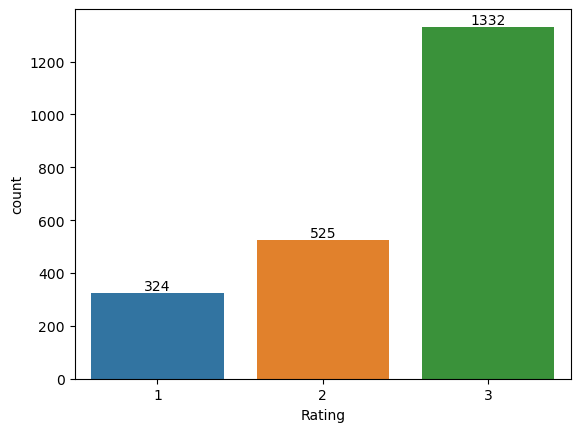

In [7]:
ax = sns.countplot(data, x = data['Rating'])
ax.bar_label(ax.containers[0])

# 4. Processing Text

In [8]:
def lower_text(text):
    return text.lower()

def alphanumeric_text(text):
    # return re.sub("[^a-z0-9\s]","", text)
    text = text.lower()
    return re.sub(r'[^\w\s.,]', '', text)

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in nltk_stopword]
    text = " ".join(text)
    # text = [stemmer.stem(word) for word in text.split(' ')]
    # text=" ".join(text)
    return text
lemmatizer = WordNetLemmatizer()

def lemmatize_word(word):
    return lemmatizer.lemmatize(word, pos='v')

def lemmatize_sentence(sentence):
    words = nltk.word_tokenize(sentence)  # convert to lower case and tokenize
    words = [word for word in words if word.isalnum()]  # filter out non-alphanumeric characters
    words = [lemmatize_word(word) for word in words]  # lemmatize each word
    return ' '.join(words)  # join the lemmatized words back into a sentence


stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

In [9]:
data['clean_text'] = data['Review'] \
                    .progress_apply(clean) \
                    .progress_apply(lemmatize_sentence) \
                    # .progress_apply(remove_duplicate_words) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (nltk_stopword)])) \
                    # .progress_apply(lower_text) \
                    # .progress_apply(alphanumeric_text) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if len(word) >= 4])) \
                    # .progress_apply(lemmatizer) \
data.head()

  0%|          | 0/2181 [00:00<?, ?it/s]

  0%|          | 0/2181 [00:00<?, ?it/s]

,Product_name,Review,Rating,clean_text
0,Lenovo Ideapad Gaming 3 Ryzen 5 Hexa Core 5600...,Best under 60k Great performanceI got it for a...,3,best great performancei get around backup bite...
1,Lenovo Ideapad Gaming 3 Ryzen 5 Hexa Core 5600...,Good perfomence...,3,good perfomence
2,Lenovo Ideapad Gaming 3 Ryzen 5 Hexa Core 5600...,Great performance but usually it has also that...,3,great performance usually also game laptops is...
3,DELL Inspiron Athlon Dual Core 3050U - (4 GB/2...,My wife is so happy and best product 👌🏻😘,3,wife happy best product
4,DELL Inspiron Athlon Dual Core 3050U - (4 GB/2...,"Light weight laptop with new amazing features,...",3,light weight laptop new amaze feature battery ...


<Axes: xlabel='text_len'>

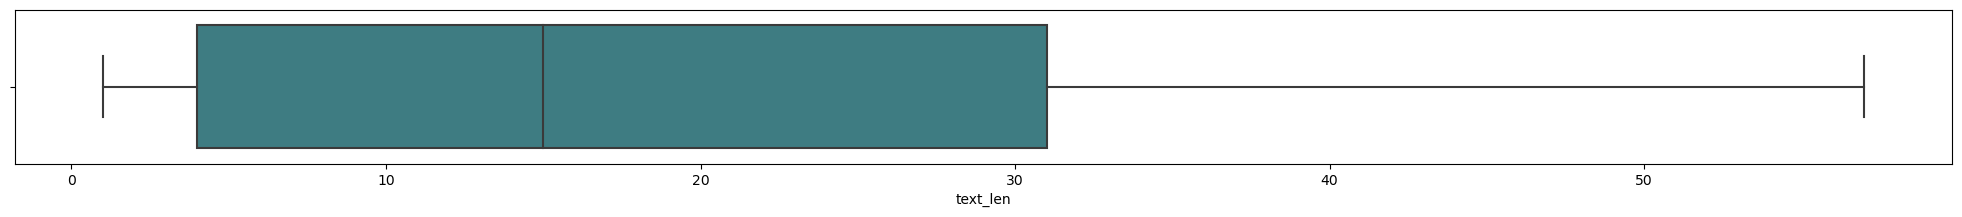

In [10]:
text_len = [len(word) for word in data['clean_text'].str.split(' ')]
data['text_len'] = pd.DataFrame(text_len)

fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="crest")

In [11]:
print(data['text_len'].quantile(.25))
print(data['text_len'].quantile(1))

4.0
57.0


4.0
57.0


<Axes: xlabel='text_len'>

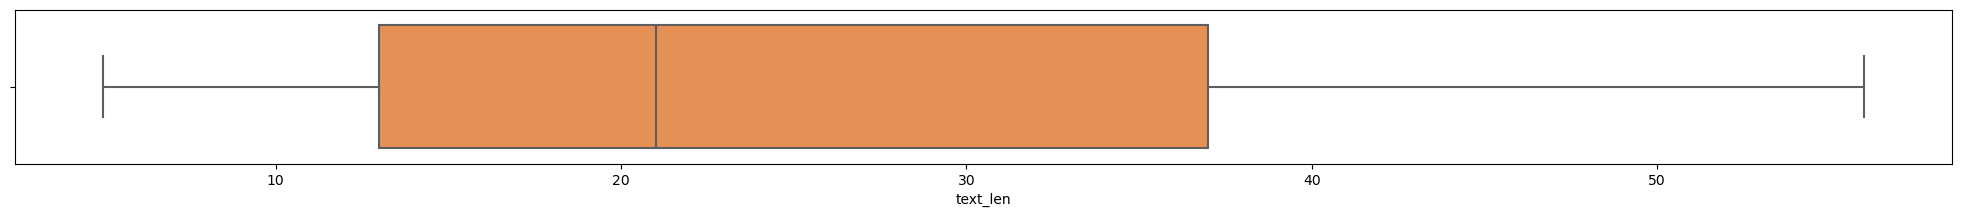

In [12]:
Q1 = data['text_len'].quantile(0.25)
Q3 = data['text_len'].quantile(1)

print(Q1)
print(Q3)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

[Text(0, 0, '219'), Text(0, 0, '382'), Text(0, 0, '920')]

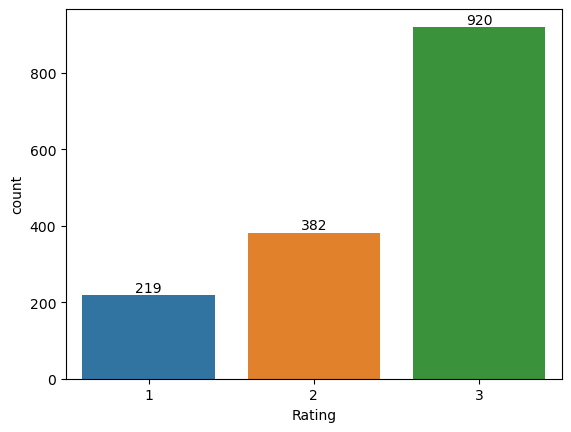

In [13]:
ax = sns.countplot(data, x = data['Rating'])
ax.bar_label(ax.containers[0])

# 5. Model

### 5.1. Splitting Data

In [14]:
X = data['clean_text']
# Y = data['CLASS'] ### For Classification Algoritms
Y = pd.get_dummies(data['Rating']) ### For Deep Learning Algoritms

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1067,)
(301,)
(153,)


### 5.2. Declare parameter for Tokenizing and Training Model process

In [17]:
vocab_size = 3425
embedding_dim = 256
max_length = 57
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

### 5.3. Tokenizing text

In [18]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

3424


# 6. Classification Algoritms

In [35]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)

model = StackingClassifier([
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('XGB', XGB),
    # ('adaboost', adaboost),
    # ('bagging', bagging),
    # ('extraTress', extraTrees),
    # ('gradient', gradient),
    # ('knn', knn),
    # ('decisionTree', decisionTree),

], n_jobs=-1)

In [ ]:
model.fit(training_padded, training_label)

In [103]:
print("Train Score        :",round((model.score(training_padded, training_label)*100), 2),'%')
print("Test Score         :",round((model.score(testing_padded, testing_label)*100), 2),'%')
print("Validating Score   :",round((model.score(validating_padded, validating_label)*100), 2),'%')

y_pred = model.predict(testing_padded)

print("R Squared Error    :",round(r2_score(testing_label, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(testing_label, y_pred), 2))

Train Score        : 100.0 %
Test Score         : 85.94 %
Validating Score   : 81.75 %
R Squared Error    : 0.44
Mean Squared Error : 0.14


In [104]:
train_predictions = model.predict(testing_padded).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

   Train Predictions  Actuals  Diff
0                  0        0     0
1                  1        1     0
2                  0        0     0
3                  0        0     0
4                  0        1     1
35 / 249


In [105]:
y_pred = model.predict(testing_padded)
print(classification_report(y_pred,testing_label))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       113
           1       0.90      0.84      0.87       136

    accuracy                           0.86       249
   macro avg       0.86      0.86      0.86       249
weighted avg       0.86      0.86      0.86       249



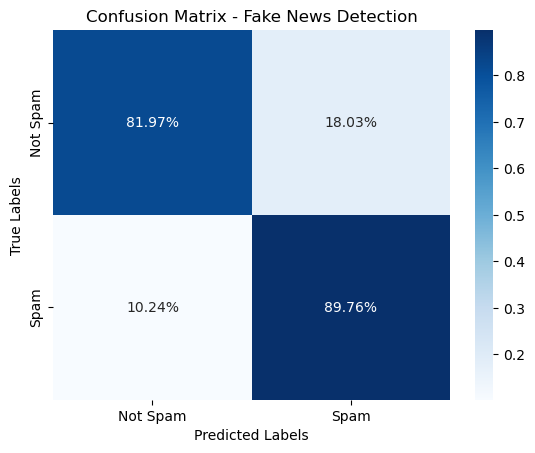

In [106]:
labels = ['Not Spam', 'Spam']

y_pred = np.rint(model.predict(testing_padded))
con_mat = confusion_matrix(testing_label,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

# 7. Deep Learning Models

In [44]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Flatten())

    model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model


def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(512, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(2, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(3, activation='softmax'))
    return model

# model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()
opt = Adam(learning_rate = 0.000_025)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 57, 256)           876800    
                                                                 
 bidirectional_7 (Bidirectio  (None, 57, 256)          296448    
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 256)              296448    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,470,467
Trainable params: 1,470,467
Non-trainable params: 0
_________________________________________________________________


In [45]:
num_epoch = 100
batch_size = 64

history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (validating_padded, validating_label))

Epoch 1/100
17/17 [==============================] - 5s 86ms/step - loss: 1.0958 - accuracy: 0.3196 - val_loss: 1.0788 - val_accuracy: 0.6340
Epoch 2/100
17/17 [==============================] - 1s 33ms/step - loss: 1.0684 - accuracy: 0.5886 - val_loss: 1.0467 - val_accuracy: 0.6601
Epoch 3/100
17/17 [==============================] - 1s 31ms/step - loss: 1.0428 - accuracy: 0.5886 - val_loss: 1.0147 - val_accuracy: 0.6601
Epoch 4/100
17/17 [==============================] - 1s 33ms/step - loss: 1.0172 - accuracy: 0.5886 - val_loss: 0.9831 - val_accuracy: 0.6601
Epoch 5/100
17/17 [==============================] - 1s 32ms/step - loss: 0.9941 - accuracy: 0.5886 - val_loss: 0.9501 - val_accuracy: 0.6601
Epoch 6/100
17/17 [==============================] - 1s 33ms/step - loss: 0.9739 - accuracy: 0.5886 - val_loss: 0.9218 - val_accuracy: 0.6601
Epoch 7/100
17/17 [==============================] - 1s 33ms/step - loss: 0.9555 - accuracy: 0.5886 - val_loss: 0.9034 - val_accuracy: 0.6601
Epoch 

### 7.1. Evaluate The Model

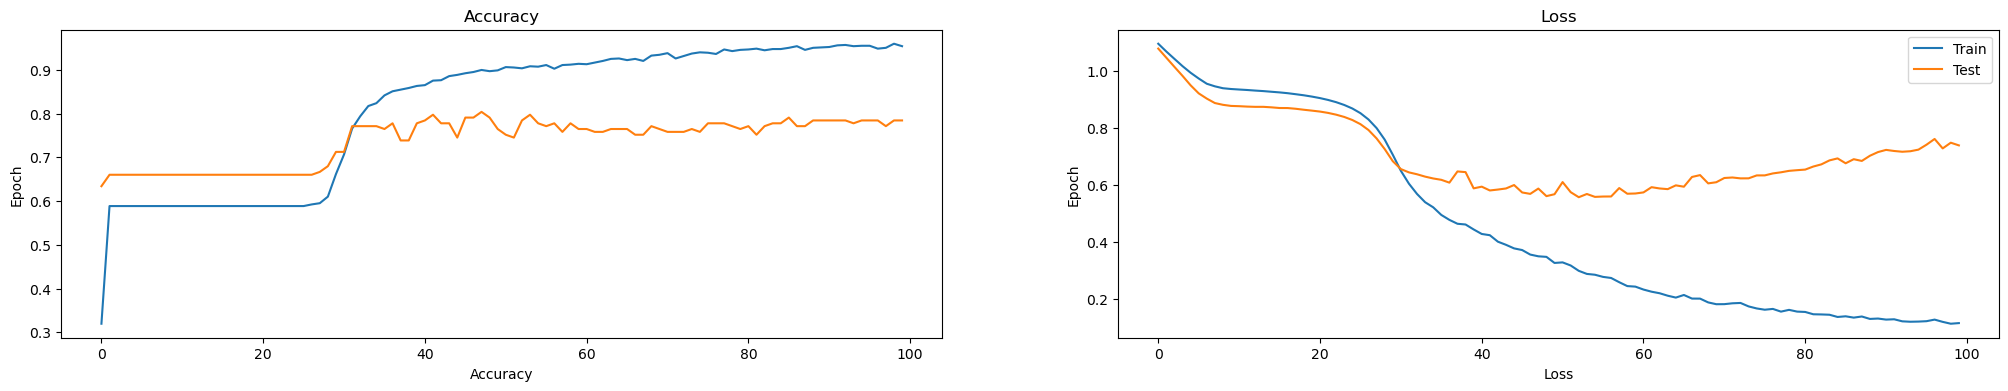

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [47]:
y_pred = model.predict(testing_padded, verbose = 0)

print("R Squared Error    :",round(r2_score(testing_label, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(testing_label, y_pred), 2))

R Squared Error    : 0.27
Mean Squared Error : 0.14


In [48]:
train_predictions = model.predict(testing_padded, verbose=0).argmax(axis=1)

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label.argmax(axis=1)})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

   Train Predictions  Actuals  Diff
0                  1        2     1
1                  1        1     0
2                  1        1     0
3                  2        2     0
4                  2        2     0
84 / 301


In [49]:
y_pred = model.predict(testing_padded, verbose=0).argmax(axis=1)
print(classification_report(y_pred,testing_label.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86        39
           1       0.70      0.50      0.58        98
           2       0.74      0.86      0.79       164

    accuracy                           0.74       301
   macro avg       0.76      0.74      0.75       301
weighted avg       0.74      0.74      0.73       301



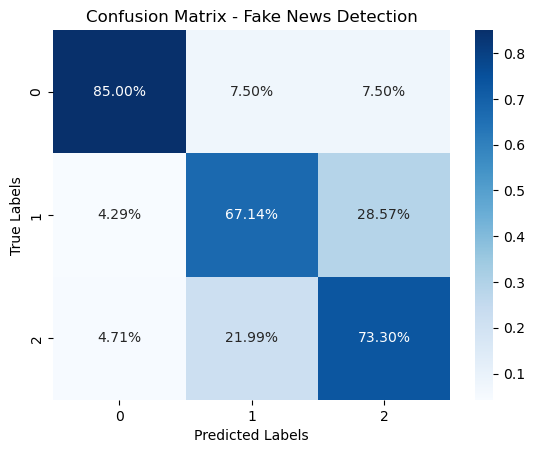

In [50]:
# labels = ['1', '2', '3', '4', '5']

y_pred = np.rint(model.predict(testing_padded, verbose=0))
con_mat = confusion_matrix(testing_label.argmax(axis=1),y_pred.argmax(axis=1))

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()